<a href="https://colab.research.google.com/github/LatifulJoy/covid19-cnn-TL-mobilenet/blob/main/covid19cnntl23_5_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import os 
import pathlib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D,SeparableConv2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix

#Downloading Dataset

In [2]:
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"latifuljoy","key":"5c49d122e1611b73411415358fb0fe9a"}'}

In [3]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [4]:
!kaggle datasets download -d sid321axn/covid-cxr-image-dataset-research

 98% 562M/572M [00:02<00:00, 219MB/s]
100% 572M/572M [00:02<00:00, 218MB/s]


In [5]:
!unzip \*.zip

Archive:  covid-cxr-image-dataset-research.zip
  inflating: COVID_IEEE/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg  
  inflating: COVID_IEEE/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg  
  inflating: COVID_IEEE/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-001.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-002.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b2.pn

In [6]:
for dirpath,dirnames,filenames in os.walk("/content/COVID_IEEE"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 3 directories and 0 images in '/content/COVID_IEEE'.
there are 0 directories and 668 images in '/content/COVID_IEEE/normal'.
there are 0 directories and 619 images in '/content/COVID_IEEE/virus'.
there are 0 directories and 536 images in '/content/COVID_IEEE/covid'.


In [7]:
data_dir = pathlib.Path("/content/COVID_IEEE")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['covid', 'normal', 'virus'], dtype='<U6')

# View The images

In [8]:
def view_image(target_dir, target_class):
    target_folder = target_dir+target_class
    random_image = random.sample(os.listdir(target_folder),1)
    print(random_image)
    img = mpimg.imread(target_folder+"/"+ random_image[0])
    plt.imshow(img, cmap ="gray")
    plt.title(target_class)
    plt.axis("off")
    print(f"image shape {img.shape}")
    
    return img

['person410_virus_821.jpeg']
image shape (1728, 2088)


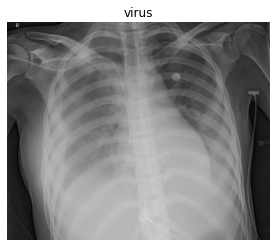

In [9]:
img = view_image("/content/COVID_IEEE/","virus")

['NORMAL2-IM-0808-0001.jpeg']
image shape (1908, 1932)


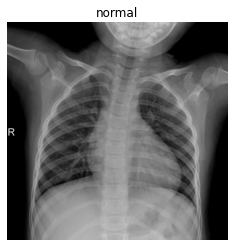

In [10]:
img = view_image("/content/COVID_IEEE/","normal")

['EUNK5-hXgAE_LZq.jfif']
image shape (2012, 2012, 3)


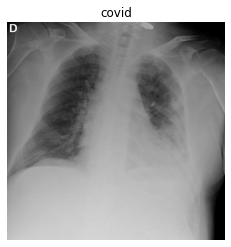

In [11]:
img = view_image("/content/COVID_IEEE/","covid")

# Resize and Normalize

In [12]:
data=[]
labels=[]
covid=os.listdir("/content/COVID_IEEE/covid/")
for a in covid:

    image = cv2.imread("/content/COVID_IEEE/covid/"+a,)
    image = cv2.resize(image, (224, 224))


    data.append(image)
    labels.append(0)

In [13]:
normal=os.listdir("/content/COVID_IEEE/normal/")
for a in normal:

    image = cv2.imread("/content/COVID_IEEE/normal/"+a,)
    image = cv2.resize(image, (224, 224))



    data.append(image)
    labels.append(1)

In [14]:
virus=os.listdir("/content/COVID_IEEE/virus/")
for a in virus:

    image = cv2.imread("/content/COVID_IEEE/virus/"+a,)
    image = cv2.resize(image, (224, 224))
    

    data.append(image)
    labels.append(2)

In [15]:
data = np.array(data) / 255.0
img_labels = np.array(labels)

In [16]:
data

array([[[[0.05098039, 0.05098039, 0.05098039],
         [0.04313725, 0.04313725, 0.04313725],
         [0.03921569, 0.03921569, 0.03921569],
         ...,
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.04313725, 0.04313725, 0.04313725]],

        [[0.04705882, 0.04705882, 0.04705882],
         [0.03921569, 0.03921569, 0.03921569],
         [0.03921569, 0.03921569, 0.03921569],
         ...,
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.04313725, 0.04313725, 0.04313725]],

        [[0.04313725, 0.04313725, 0.04313725],
         [0.03529412, 0.03529412, 0.03529412],
         [0.03921569, 0.03921569, 0.03921569],
         ...,
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.04313725, 0.04313725, 0.04313725]],

        ...,

        [[0.0745098 , 0.0745098 , 0.0745098 ],
         [0.0745098 , 0.0745098 , 0.0745098 ]

# Spliting The Dataset

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, img_labels, test_size=0.20, random_state=42)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [18]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

# Convolutional Sequential Model(CNN)

In [19]:
model = Sequential()

#Block Number 1
model.add(Conv2D(input_shape = (224,224,3), filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

Dropout(0.25)

#Block Number 2
model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))


model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))
model.add(MaxPool2D((2,2)))
Dropout(0.25)

#Block Number 3
model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))
Dropout(0.25)

#Block Number 4
model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))
Dropout(0.25)

# Fully Connected layer
model.add(Flatten())

model.add(Dense(units=1024, activation="relu"))
Dropout(0.25)

model.add(Dense(units=128, activation="relu"))
Dropout(0.25)

model.add(Dense(units=3, activation="softmax"))

model.compile(optimizer= opt ,loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                        

In [21]:
model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32)

Epoch 1/20
37/37 [==============================] - 19s 169ms/step - loss: 1.0125 - accuracy: 0.4528 - val_loss: 0.8262 - val_accuracy: 0.5651
Epoch 2/20
37/37 [==============================] - 5s 126ms/step - loss: 0.6247 - accuracy: 0.7238 - val_loss: 0.6396 - val_accuracy: 0.6027
Epoch 3/20
37/37 [==============================] - 4s 120ms/step - loss: 0.4675 - accuracy: 0.8336 - val_loss: 0.4372 - val_accuracy: 0.8459
Epoch 4/20
37/37 [==============================] - 4s 121ms/step - loss: 0.3252 - accuracy: 0.8851 - val_loss: 0.2966 - val_accuracy: 0.8973
Epoch 5/20
37/37 [==============================] - 5s 129ms/step - loss: 0.2392 - accuracy: 0.9168 - val_loss: 0.2787 - val_accuracy: 0.9110
Epoch 6/20
37/37 [==============================] - 5s 123ms/step - loss: 0.2131 - accuracy: 0.9237 - val_loss: 0.2662 - val_accuracy: 0.9075
Epoch 7/20
37/37 [==============================] - 5s 124ms/step - loss: 0.2009 - accuracy: 0.9280 - val_loss: 0.2817 - val_accuracy: 0.8938
Epoch

Text(0.5, 1.0, 'Training-Validation Accuracy')

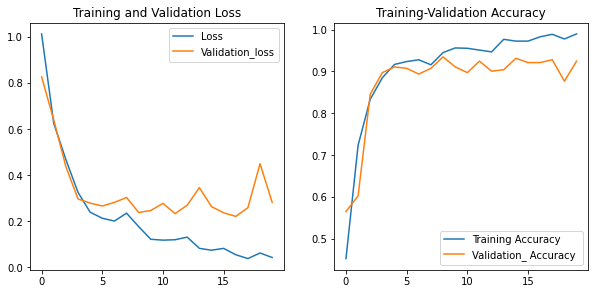

In [22]:
#saving the model history
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy 
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

In [23]:
predictions = model.predict(X_test)

y_pred = np.argmax(predictions, axis = 1)
y_test_new = np.argmax(y_test, axis = 1)

In [24]:
print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       108
           1       0.98      0.92      0.95       129
           2       0.95      0.96      0.96       128

    accuracy                           0.96       365
   macro avg       0.96      0.96      0.96       365
weighted avg       0.96      0.96      0.96       365



In [25]:
pd.DataFrame(confusion_matrix(y_test_new, y_pred), columns= ["covid", "normal", "virus"], index = ["covid", "normal", "virus"])

,covid,normal,virus
covid,107,1,0
normal,4,119,6
virus,3,2,123


## MobileNet

In [26]:
base_model = tf.keras.applications.MobileNet(input_shape=[224,224,3], weights = "imagenet", include_top=False)

for layer in base_model.layers:
  layer.trainable =False

17235968/17225924 [==============================] - 1s 0us/step


In [27]:
model = Flatten()(base_model.output)

model = Dense(units=1024, activation="relu")(model)
model = Dense(units=512, activation="relu")(model)
model = Dense(units=256, activation="relu")(model)
model = Dense(units=128, activation="relu")(model)
Dropout(0.25)


prediction_layer = Dense(units=3, activation="softmax")(model)

In [28]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

In [29]:
model = Model(inputs = base_model.input, outputs = prediction_layer)
model.compile(optimizer= opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [31]:
model.fit(X_train, y_train, validation_split=0.2, epochs=15, batch_size=32)

Epoch 1/15
37/37 [==============================] - 5s 88ms/step - loss: 6.5800 - accuracy: 0.7238 - val_loss: 1.9234 - val_accuracy: 0.8904
Epoch 2/15
37/37 [==============================] - 2s 59ms/step - loss: 0.4254 - accuracy: 0.9528 - val_loss: 0.4581 - val_accuracy: 0.9418
Epoch 3/15
37/37 [==============================] - 2s 60ms/step - loss: 0.1116 - accuracy: 0.9880 - val_loss: 0.4893 - val_accuracy: 0.9452
Epoch 4/15
37/37 [==============================] - 2s 67ms/step - loss: 0.0196 - accuracy: 0.9949 - val_loss: 0.2638 - val_accuracy: 0.9692
Epoch 5/15
37/37 [==============================] - 2s 59ms/step - loss: 0.1526 - accuracy: 0.9811 - val_loss: 0.6281 - val_accuracy: 0.9486
Epoch 6/15
37/37 [==============================] - 2s 60ms/step - loss: 0.1241 - accuracy: 0.9897 - val_loss: 0.3271 - val_accuracy: 0.9760
Epoch 7/15
37/37 [==============================] - 2s 67ms/step - loss: 0.1279 - accuracy: 0.9811 - val_loss: 0.4179 - val_accuracy: 0.9658
Epoch 8/15
37

Text(0.5, 1.0, 'Training-Validation Accuracy')

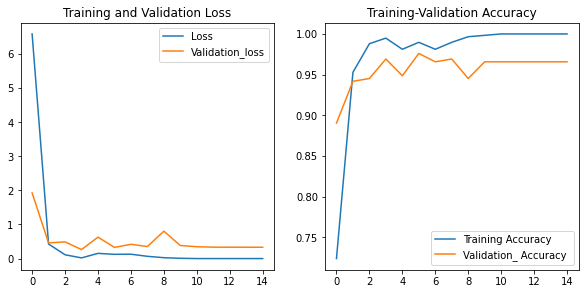

In [32]:
#saving the model history
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy 
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

In [33]:
predictions = model.predict(X_test)

y_pred = np.argmax(predictions, axis = 1)
y_test_new = np.argmax(y_test, axis = 1)

In [34]:
print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       108
           1       0.96      0.96      0.96       129
           2       0.98      0.95      0.96       128

    accuracy                           0.97       365
   macro avg       0.97      0.97      0.97       365
weighted avg       0.97      0.97      0.97       365



In [35]:
pd.DataFrame(confusion_matrix(y_test_new, y_pred), columns= ["covid", "normal", "virus"], index = ["covid", "normal", "virus"])

,covid,normal,virus
covid,108,0,0
normal,2,124,3
virus,2,5,121


## DenseNet121

In [36]:
densenet = tf.keras.applications.DenseNet121(input_shape=[224,224,3], weights = "imagenet", include_top=False)

for layer in densenet.layers:
  layer.trainable =False

29097984/29084464 [==============================] - 0s 0us/step


In [37]:
model = Flatten()(densenet.output)

model = Dense(units=1024, activation="relu")(model)
model = Dense(units=512, activation="relu")(model)
model = Dense(units=256, activation="relu")(model)
model = Dense(units=64, activation="relu")(model)

prediction_layer = Dense(units=3, activation="softmax")(model)

In [38]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=.0001)

In [39]:
model = Model(inputs = densenet.input, outputs = prediction_layer)
model.compile(optimizer=opt ,loss='categorical_crossentropy',metrics=['accuracy'])

In [40]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [41]:
model.fit(X_train, y_train, validation_split=0.2, epochs=15, batch_size=32)

Epoch 1/15
37/37 [==============================] - 16s 243ms/step - loss: 0.4142 - accuracy: 0.8465 - val_loss: 0.1695 - val_accuracy: 0.9281
Epoch 2/15
37/37 [==============================] - 5s 140ms/step - loss: 0.0887 - accuracy: 0.9640 - val_loss: 0.1290 - val_accuracy: 0.9452
Epoch 3/15
37/37 [==============================] - 5s 141ms/step - loss: 0.0454 - accuracy: 0.9820 - val_loss: 0.0797 - val_accuracy: 0.9658
Epoch 4/15
37/37 [==============================] - 5s 142ms/step - loss: 0.0252 - accuracy: 0.9949 - val_loss: 0.0806 - val_accuracy: 0.9658
Epoch 5/15
37/37 [==============================] - 5s 142ms/step - loss: 0.0118 - accuracy: 0.9957 - val_loss: 0.1337 - val_accuracy: 0.9486
Epoch 6/15
37/37 [==============================] - 5s 140ms/step - loss: 0.0148 - accuracy: 0.9940 - val_loss: 0.0944 - val_accuracy: 0.9658
Epoch 7/15
37/37 [==============================] - 5s 149ms/step - loss: 0.0071 - accuracy: 0.9983 - val_loss: 0.0802 - val_accuracy: 0.9726
Epoch

Text(0.5, 1.0, 'Training-Validation Accuracy')

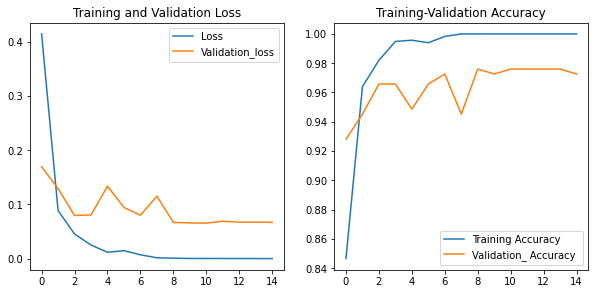

In [42]:
#saving the model history
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy 
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

In [43]:
predictions = model.predict(X_test)

y_pred = np.argmax(predictions, axis = 1)
y_test_new = np.argmax(y_test, axis = 1)

In [44]:
print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       108
           1       0.97      0.98      0.97       129
           2       0.98      0.97      0.98       128

    accuracy                           0.98       365
   macro avg       0.98      0.98      0.98       365
weighted avg       0.98      0.98      0.98       365



In [45]:
pd.DataFrame(confusion_matrix(y_test_new, y_pred), columns= ["covid", "normal", "virus"], index = ["covid", "normal", "virus"])

,covid,normal,virus
covid,107,1,0
normal,1,126,2
virus,1,3,124
